# 손실 함수 (Loss Function)

In [112]:
import numpy as np

# mse: 실제값과 예측값의 제곱의 평균
def mean_sqaured_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# mae: 실제값과 예측값 차이의 절대값의 평균
def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

In [113]:
y_true = np.array([1.0, 2.0, 3.0, 4.0, 5.0])
y_pred = np.array([1.2, 1.8, 3.1, 3.9, 4.8])

mse = mean_sqaured_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

print('mse', mse)
print('mae', mae)

mse 0.028000000000000014
mae 0.16000000000000006


In [114]:
y_true = np.array([1.0, 2.0, 3.0, 4.0, 5.0])
y_pred = np.array([1.2, 1.8, 3.1, 3.9, 4.8])

# 예측값이 틀리게끔 이상치 append
y_true = np.append(y_true, [50.0, 60.0]) 
y_pred = np.append(y_pred, [10.0, 5.0])

mse = mean_sqaured_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

print('mse', mse)
print('mae', mae)

mse 660.7342857142858
mae 13.685714285714285


In [115]:
def huber_loss(y_true, y_pred, delta=1.0):
    error = y_true - y_pred                         # 잔차
    is_small_error = np.abs(error) <= delta         # if |잔차| <= delta 수식을 그대로 코드로 나타냄 # mse
    squared_loss = 0.5 * (error ** 2)               # 1/2 * (잔차)**2
    linear_loss = delta * (np.abs(error) - 0.5 * delta) # mae
    return np.mean(np.where(is_small_error, squared_loss, linear_loss))

huber_loss(y_true, y_pred) 
# 이상치 제외한 값: np.float64(0.014000000000000007): mse에 가까워보여서 mse가 반영이 되었다는 것을 예측할 수 있음
# 이상치 포함한 값: np.float64(13.438571428571427): 위의 조건에 따라 mae가 적용이 되어서 이상치가 추가되었음에도 손실값을 안정적으로 계산해줌

np.float64(13.438571428571427)

---

### 신경망 모델에서 손실함수 활용

In [116]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 데이터 생성
X, y = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=15,   # 중요한 특성 잡아주기
    n_redundant=5,      # 15개의 중요 특성을 가지고 선형 결합을 해서 만들어지는 특성, 학습 자체에는 관여되지 않는 속성
    n_classes=2,        # 클래스는 2개
    random_state=42     # 난수 고정
)

# 전처리
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

# 원핫 인코딩 적용
def one_hot(labels, num_classes):
    return np.eye(num_classes)[labels] # 대각선 라인만 1로 채우고 나머지는 0으로 

y_train_oh = one_hot(y_train, 2)
y_test_oh = one_hot(y_test, 2)

In [117]:
# 모델 파라미터 초기화
# 모델 파라미터: 모델이 가진 가중치나 편향을 의미
# 하이퍼 파라미터랑 다름?

np.random.seed(42)

input_dim = X_train.shape[1] # 특성의 수만큼 dim을 정해줌
hidden_dim = 32 # 은닉 층의 뉴런 수
output_dim = 2 # 이진분류라 output_dim을 2로

# 1. input layer -> hidden layer로 갈 때 가중치와 편향이 있고
# 2. hidden layer -> output layer로 갈 떄 가중치와 편향이 있음
W1 = np.random.randn(input_dim, hidden_dim) # 1
b1 = np.zeros((1, hidden_dim)) # 1
W2 = np.random.randn(hidden_dim, output_dim) # 2
b2 = np.zeros((1, output_dim)) # 2

In [118]:
# 활성화 함수, 손실 함수 정의
def relu(z): # 은닉층으로 갈 때는 relu
    return np.maximum(0, z)

# 출력층으로 갈 때는 softmax
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  # 오버플로우를 방지하기 위해 z값에서 max값을 빼줌
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def cross_entrophy_loss(probs, labels):
    m = labels.shape[0]
    log_likelihood = -np.log(probs + 1e-8) * labels # 1e-8: 1*10^(-8)
    loss = np.sum(log_likelihood)/m
    return loss

In [119]:
# 학습
learning_rate = 0.01
epochs = 100
train_losses = []
test_losses = []

for epoch in range(epochs):
    # Forward - 가중치로 내적한 후 활성화 함수 통과
    Z1 = np.dot(X_train, W1) + b1
    R1 = relu(Z1)   # shape: (hidden_dim, output_dim) # 은닉층의 output은 R1
    Z2 = np.dot(R1, W2) + b2
    probs = softmax(Z2) # 소프트맥스 함수를 통과하면 예측치가 나와서 props라는 변수명으로 받아줌
    loss = cross_entrophy_loss(probs, y_train_oh)

    # Backpropagation
    m = X_train.shape[0] # 데이터 개수
    dZ2 = (probs - y_train_oh) / m # 가중치 기울기를 미분을 통해 구해줌 # 직전의 기울기 구하기 # shape: (N, output_dim)
    dW2 = np.dot(R1.T, dZ2) # shape이 전치가 되어야만 내적이 됨
    db2 = np.sum(dZ2, axis=0, keepdims=True)

    dR1 = np.dot(dZ2, W2.T)
    dZ1 = dR1 * (Z1 > 0) # relu 미분
    dW1 = np.dot(X_train.T, dZ1)
    db1 = np.sum(dZ1, axis=0, keepdims=True)

    # 파라미터 업데이트
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2

    train_losses.append(loss)

    # 테스트 데이터로 손실 확인
    Z1_test = np.dot(X_test, W1) + b1
    R1_test = relu(Z1_test)   # shape: (hidden_dim, output_dim)
    Z2_test = np.dot(R1_test, W2) + b2
    probs_test = softmax(Z2_test) # 소프트맥스 함수를 통과하면 예측치가 나와서 props라는 변수명으로 받아줌
    loss_test = cross_entrophy_loss(probs_test, y_test_oh)
   
    test_losses.append(loss_test)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1} | 학습손실: {loss: .4f}, 테스트 손실: {loss_test: .4f}')

Epoch 10 | 학습손실:  4.4511, 테스트 손실:  4.4685
Epoch 20 | 학습손실:  4.0039, 테스트 손실:  4.0507
Epoch 30 | 학습손실:  3.6635, 테스트 손실:  3.7196
Epoch 40 | 학습손실:  3.3840, 테스트 손실:  3.4576
Epoch 50 | 학습손실:  3.1472, 테스트 손실:  3.2343
Epoch 60 | 학습손실:  2.9433, 테스트 손실:  3.0472
Epoch 70 | 학습손실:  2.7649, 테스트 손실:  2.8778
Epoch 80 | 학습손실:  2.6023, 테스트 손실:  2.7088
Epoch 90 | 학습손실:  2.4508, 테스트 손실:  2.5528
Epoch 100 | 학습손실:  2.3104, 테스트 손실:  2.4099


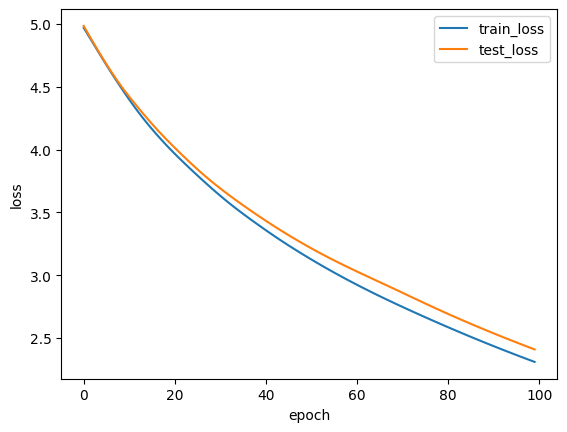

In [120]:
# 시각화
plt.plot(range(epochs), train_losses, label='train_loss')
plt.plot(range(epochs), test_losses, label='test_loss')

plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

### 기본 손실 함수 vs 커스텀 손실 함수

In [121]:
from sklearn.datasets import make_regression

# 데이터 생성
X, y = make_regression(
    n_samples=1000,
    n_features=10,
    noise=50,
    random_state=42
)

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y.reshape(-1,1)).flatten() # y는 1차원이기 때문에 reshape한 후 스케일링하고 스케일링이 끝나면 1차원으로 돌려놓기

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [122]:
# 예측 함수
def predict(X, w, b):
    return np.dot(X, w) + b

In [137]:
# 손실 함수
def mse_loss(y_pred, y_true):
    return np.mean((y_pred - y_true) ** 2)

# 커스텀 손실 함수 - 기존 mse에 L2 규제 추가
def my_loss(y_pred, y_true, w, lambda_reg=1.0): # lambda_reg: 규제정도
    mse = mse_loss(y_pred, y_true)
    l2_reg = np.sum(w**2)
    return mse + (lambda_reg * l2_reg) # 기존 손실에 제곱합을 더해줌 이때 제곱합은 규제정도임

In [138]:
# 학습 함수
def train_model(X_train, y_train, X_test, y_test, loss_fn, epochs=50, learning_rate=0.1, use_custom=False): # epoch을 30번까지만 해도 손실이 같게 나왔을것
    np.random.seed(42)
    n_features = X_train.shape[1]
    W = np.random.randn(n_features)
    b = 0.0

    for epoch in range(epochs):
        y_pred_train = predict(X_train, W, b)
        y_pred_test = predict(X_test, W, b)

        train_loss = loss_fn(y_pred_train, y_train, W) if use_custom else loss_fn(y_pred_train, y_train)
        test_loss = loss_fn(y_pred_test, y_test, W) if use_custom else loss_fn(y_pred_test, y_test)

        d_loss = 2 * (y_pred_train - y_train) / X_train.shape[0]
        grad_w = np.dot(X_train.T, d_loss)
        grad_b = np.sum(d_loss)

        if use_custom:
            grad_w += 2 * 1.0 * W
        
        # 파라미터 업데이트
        W -= learning_rate * grad_w
        b -= learning_rate * grad_b

        if (epoch + 1) % 10 == 0:
            print(f'Epoch: {epoch+1} | 학습 손실:{train_loss: .4f}, 테스트 손실: {test_loss: .4f}')

In [139]:
train_model(X_train, y_train, X_test, y_test, mse_loss)

Epoch: 10 | 학습 손실: 0.1782, 테스트 손실:  0.1833
Epoch: 20 | 학습 손실: 0.1216, 테스트 손실:  0.1255
Epoch: 30 | 학습 손실: 0.1209, 테스트 손실:  0.1242
Epoch: 40 | 학습 손실: 0.1209, 테스트 손실:  0.1241
Epoch: 50 | 학습 손실: 0.1209, 테스트 손실:  0.1241


In [140]:
train_model(X_train, y_train, X_test, y_test, my_loss, use_custom=True)

Epoch: 10 | 학습 손실: 0.5709, 테스트 손실:  0.5544
Epoch: 20 | 학습 손실: 0.5698, 테스트 손실:  0.5548
Epoch: 30 | 학습 손실: 0.5698, 테스트 손실:  0.5550
Epoch: 40 | 학습 손실: 0.5698, 테스트 손실:  0.5550
Epoch: 50 | 학습 손실: 0.5698, 테스트 손실:  0.5550


---

### 손실 함수 선택이 모델 성능에 미치는 영향

In [154]:
make_regression(
    n_samples=1000,
    n_features=5,
    noise=30,
    random_state=42
)

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y.reshape(-1,1)).flatten() 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [155]:
# 선형 회귀 모델 예측 함수
def predict(X, W, b):
    return np.dot(X, W) + b

In [156]:
# 손실 함수
def mse_loss(y_pred, y_true):
    return np.mean((y_pred - y_true) ** 2)

def mae_loss(y_pred, y_true):
    return np.mean(np.abs(y_pred - y_true))

def huber_loss(y_pred, y_true, delta=1.0):
    error = y_pred - y_true
    is_small_error = np.abs(error) <= delta
    squared_error = 0.5 * error ** 2
    linear_error = delta * (np.abs(error) - 0.5 * delta)
    return np.mean(np.where(is_small_error, squared_error, linear_error))

In [177]:
def train_regression(X, y, loss_fn, epochs=100, learning_rate=0.01):
    n_features = X.shape[1]
    W = np.random.randn(n_features)
    b = 0.0
    m = X.shape[0]
    epsilon = 1e-5
    losses = []

    for epoch in range(epochs):
        y_pred = predict(X, W, b)
        loss = loss_fn(y_pred, y)
        losses.append(loss) # 에폭 돌 때마다 loss 값이 저장되게

        grad_w = np.zeros_like(W) # 0으로 초기화
        for i in range(len(W)): # 가중치의 개수만큼 반복
            # 수치 미분을 사용해서 기울기를 조정
            W_eps = np.copy(W) # 원본 가중치를 그대로 W_eps에 복사
            W_eps[i] += epsilon # 아주 작은 값을 복사한 가중치 리스트에 더해 조금의 차이를 만듦
            loss_eps = loss_fn(predict(X, W_eps, b), y)
            grad_w[i] = (loss_eps - loss) / epsilon
        
        b_eps = b + epsilon
        loss_eps_b = loss_fn(predict(X, W, b_eps), y)
        grad_b = (loss_eps_b - loss) /epsilon
        
        W -= learning_rate * grad_w
        b -= learning_rate * grad_b

    return W,b, losses

In [178]:
results = {}

for name, loss_fn in zip(['MSE','MAE','Huber'], [mse_loss, mae_loss, huber_loss]):
    W,b,losses = train_regression(X_train, y_train, loss_fn) # 모델 파라미터 반환받아서
    results[name] = {'losses': losses}

    pred_test = predict(X_test, W, b) # 예측하기
    test_loss = mse_loss(pred_test, y_test)
    print(f'{name} Loss: {test_loss: .4f}')

# mse와 mae의 중간값으로 나오는게 맞지만 delta에 따라 값이 달라져  mse나 mae에 둘 중 하나에 가깝게 나오게 되는거임
# delta 값을 기준으로 해서 mse나 mae를 취하고 있음

MSE Loss:  0.4247
MAE Loss:  5.5727
Huber Loss:  4.1530


In [179]:
print(results.items())

dict_items([('MSE', {'losses': [np.float64(16.243223457328238), np.float64(15.59597153196375), np.float64(14.974949671842213), np.float64(14.379085408103379), np.float64(13.807350491503255), np.float64(13.258759054703463), np.float64(12.732365851443006), np.float64(12.227264569621239), np.float64(11.742586214693207), np.float64(11.277497560922221), np.float64(10.831199667253678), np.float64(10.402926455315187), np.float64(9.991943346753498), np.float64(9.597545957554884), np.float64(9.219058846906227), np.float64(8.855834318233496), np.float64(8.507251270348734), np.float64(8.172714096524139), np.float64(7.851651629453875), np.float64(7.543516130188864), np.float64(7.247782319325318), np.float64(6.963946448455432), np.float64(6.691525410372752), np.float64(6.430055886278442), np.float64(6.179093528552385), np.float64(5.938212177488308), np.float64(5.707003110645927), np.float64(5.485074323409764), np.float64(5.272049839506873), np.float64(5.06756905011007), np.float64(4.871286080464334

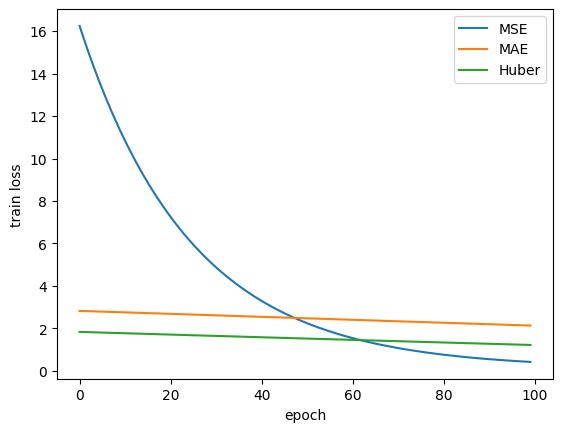

In [180]:
# 시각화
for name, value in results.items():
    plt.plot(value['losses'], label=name)

plt.xlabel('epoch')
plt.ylabel('train loss')
plt.legend()
plt.show()